# ONE HOT ENCODING

# Imports libraries

In [1]:
vocab_size = 100000  #number of unique words
embedding_dim = 16
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 200000

https://www.actuia.com/keras/debuter-avec-le-modele-sequentiel-de-keras/

https://inside-machinelearning.com/en/efficient-sentences-embedding-visualization-tsne/#Preparing_the_data_-_GoEmotions

https://vitalflux.com/keras-categorical-cross-entropy-loss-function/ sur les loss : categorical_cross, binary_cross

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
import os
print(tf.__version__)
#!pip install -q tensorflow-datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

2.9.2


# Load and transform the data

We concatenate the 3 dataframes so we can deal with a single one.
We drop all the useless columns in the dataframe and only keep the sentiment and the tweet associated to it.

We also reset the index because we concatenated the 3 goemotions so without that we would have 3 rows with the same index

In [3]:
goemotions_1 = pd.read_csv('goemotions_1.csv') #load the dataset
goemotions_2 = pd.read_csv('goemotions_2.csv') #load the dataset
goemotions_3 = pd.read_csv('goemotions_3.csv') #load the dataset


In [4]:
# concat 3 df
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames)
# drop others columns
df.drop(['id','author','subreddit','link_id','parent_id','created_utc','rater_id', 'example_very_unclear'], inplace=True, axis=1)
df.reset_index(drop=True, inplace=True)
df.shape


(211225, 29)

# We assign the following variables :
- sentences : the column "text" of df that refers to all the tweets in the dataframe
- labels : sentiment get dummies of the dataframe, all the sentiment columns so from the index 1 (index 0 being the text) to the last column)
There are 28 sentiments in the dataframe

In [5]:
sentences = df['text']
# df of all the 28 emotions
labels = df.iloc[:, 1:]
#labels.shape
labels

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create train and test

We associate to training_sentences the tweets for the training size so from 0 to 200 000

The testing_sentences is all the tweet from 200 000 to the end of the dataframe

The training_labels takes all the labels associated to the tweets for the training size (0 to 200 0000)
The testing_labels takes the ramaining labels

In [6]:
# training_sentences select the text, testing_labels the labels associated
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# training_sentences[0] is the first tweet in training_sentences


We tokenize training_sentences and testing_sentences

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# make all the sentences of equal size, add zeros at the end of the sentencses to fill max tweet lenght

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

# -------------------------------------------------- ACURACY METRIC -----------------------------------------------------

# MODEL 1 loss = binary cross entropy

# Hyperparameters
The whole dataset is 211225 so we split inot a training size of 200 000 and the rest is the test set.

We set the maximum vocabulary size to 10 000 and the maximum lenght of a tweet to 150

703 is the longest tweet size

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 80, 16)            1600000   
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               2176      
                                                                 
 dense_9 (Dense)             (None, 28)                3612      
                                                                 
Total params: 1,605,788
Trainable params: 1,605,788
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/20
6250/6250 - 17s - loss: 0.1598 - accuracy: 0.2652 - val_loss: 0.1478 - val_accuracy: 0.2971 - 17s/epoch - 3ms/step
Epoch 2/20
6250/6250 - 16s - loss: 0.1425 - accuracy: 0.3158 - val_loss: 0.1369 - val_accuracy: 0.3395 - 16s/epoch - 3ms/step
Epoch 3/20
6250/6250 - 16s - loss: 0.1311 - accuracy: 0.3650 - val_loss: 0.1299 - val_accuracy: 0.3668 - 16s/epoch - 3ms/step
Epoch 4/20
6250/6250 - 16s - loss: 0.1239 - accuracy: 0.3881 - val_loss: 0.1258 - val_accuracy: 0.3840 - 16s/epoch - 3ms/step
Epoch 5/20
6250/6250 - 17s - loss: 0.1191 - accuracy: 0.4063 - val_loss: 0.1245 - val_accuracy: 0.3903 - 17s/epoch - 3ms/step
Epoch 6/20
6250/6250 - 16s - loss: 0.1157 - accuracy: 0.4182 - val_loss: 0.1236 - val_accuracy: 0.3955 - 16s/epoch - 3ms/step
Epoch 7/20
6250/6250 - 16s - loss: 0.1132 - accuracy: 0.4281 - val_loss: 0.1228 - val_accuracy: 0.3919 - 16s/epoch - 3ms/step
Epoch 8/20
6250/6250 - 16s - loss: 0.1111 - accuracy: 0.4355 - val_loss: 0.1232 - val_accuracy: 0.3943 - 16s/epoch - 3

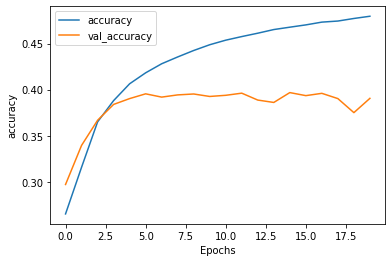

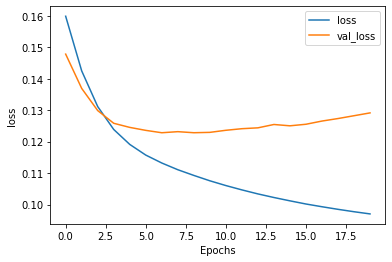

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Conclusion :

the model seems to behave well after each iteration of optimization but the loss stagnates and so the accuracy doesn't go beyond 0.4. The model tends to overfit a little bit at the end.

I try another way to predict the sentiment by having a label encoding instead of a one hot encoding process

# MODEL 1 WITH DIFFERENT PARAMETERS vocab_size

# ----------------------------------------------- AUC METRIC -----------------------------------------------------

# MODEL 1

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC()])
model.summary()

num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 16)            1600000   
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               2176      
                                                                 
 dense_7 (Dense)             (None, 28)                3612      
                                                                 
Total params: 1,605,788
Trainable params: 1,605,788
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6250/6250 - 21s - loss: 0.1610 - auc_2: 0.7355 - val_loss: 0.1503 - val_auc_2: 0.7714 - 21s/epoch -

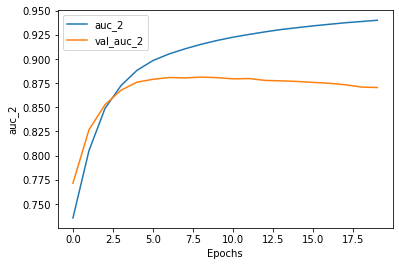

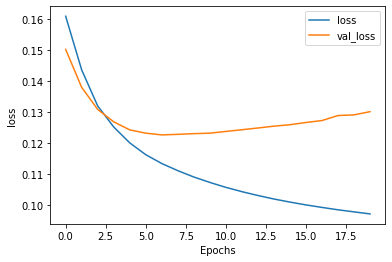

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_2")
plot_graphs(history, "loss")

The loss decreases and the accuracy increases so the training process is efficient. There is no overfitting

# MODEL 1 with dropout

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC()])
model.summary()

num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 16)            1600000   
                                                                 
 dropout_1 (Dropout)         (None, 80, 16)            0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               2176      
                                                                 
 dense_5 (Dense)             (None, 28)                3612      
                                                                 
Total params: 1,605,788
Trainable params: 1,605,788
Non-trainable params: 0
____________________________________________

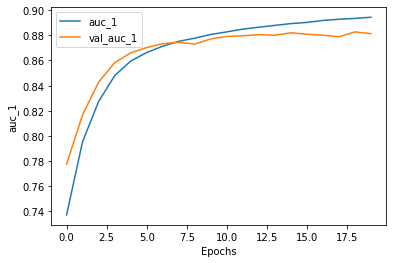

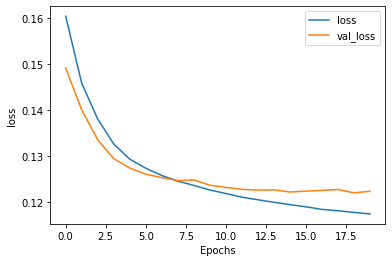

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_1")
plot_graphs(history, "loss")

# Other model evaluated less conclusive

# MODEL 2

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(8, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28 , activation='sigmoid')  # change its shape to the maximum output label.
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

#model.summary()

loss='categorical_crossentropy' : auc_2: 0.5032 

In [ ]:
# keras.utils.plot_model(model, "27 sentiments analysis.png", show_shapes=True)

In [ ]:
from keras.callbacks import LearningRateScheduler

# # we add learning rate scheduler to change because we are on a plateau
# # for that we add it in callback

# callbacks = [
#     ReduceLROnPlateau(), # monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced
#     ModelCheckpoint(filepath='model_sparse', save_best_only=True)
# ]

##############################
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]
################################
#callbacks = keras.callbacks.ModelCheckpoint("model_sparse.h5", save_best_only=True)



In [ ]:
num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
6250/6250 - 60s - loss: 0.1570 - auc_3: 0.7611 - val_loss: 0.1443 - val_auc_3: 0.8015 - 60s/epoch - 10ms/step
Epoch 2/10
6250/6250 - 57s - loss: 0.1412 - auc_3: 0.8171 - val_loss: 0.1377 - val_auc_3: 0.8289 - 57s/epoch - 9ms/step
Epoch 3/10
6250/6250 - 57s - loss: 0.1340 - auc_3: 0.8440 - val_loss: 0.1341 - val_auc_3: 0.8404 - 57s/epoch - 9ms/step
Epoch 4/10
6250/6250 - 56s - loss: 0.1293 - auc_3: 0.8585 - val_loss: 0.1312 - val_auc_3: 0.8519 - 56s/epoch - 9ms/step
Epoch 5/10
6250/6250 - 56s - loss: 0.1244 - auc_3: 0.8729 - val_loss: 0.1288 - val_auc_3: 0.8596 - 56s/epoch - 9ms/step
Epoch 6/10
6250/6250 - 57s - loss: 0.1203 - auc_3: 0.8844 - val_loss: 0.1271 - val_auc_3: 0.8660 - 57s/epoch - 9ms/step
Epoch 7/10
6250/6250 - 56s - loss: 0.1172 - auc_3: 0.8923 - val_loss: 0.1267 - val_auc_3: 0.8672 - 56s/epoch - 9ms/step
Epoch 8/10
6250/6250 - 56s - loss: 0.1149 - auc_3: 0.8982 - val_loss: 0.1261 - val_auc_3: 0.8700 - 56s/epoch - 9ms/step
Epoch 9/10
6250/6250 - 56s - loss: 0.11

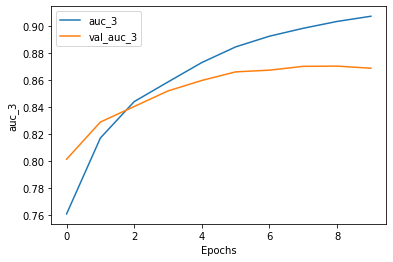

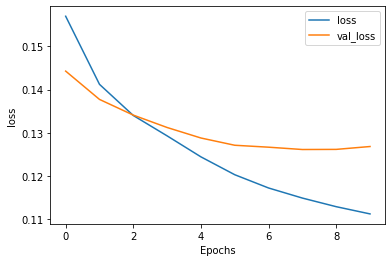

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_3")
plot_graphs(history, "loss")

# MODEL 3

In [ ]:
#  Here the length refers to the number of rows of the filter, 
# here it is the dimension of the entire word embedding or the entire character representation
filter_length = 300


model = tf.keras.Sequential()
model.add(Embedding(vocab_size, 20, input_length=max_length))
#model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(training_labels.shape[1]))
model.add(Activation('sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()]) # pas de multi_label =True car < accuracy

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]


num_epochs= 10
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, callbacks=callbacks, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
6250/6250 - 26s - loss: 0.1321 - auc_4: 0.8532 - val_loss: 0.1205 - val_auc_4: 0.8874 - lr: 0.0010 - 26s/epoch - 4ms/step
Epoch 2/10
6250/6250 - 22s - loss: 0.1158 - auc_4: 0.9000 - val_loss: 0.1180 - val_auc_4: 0.8945 - lr: 0.0010 - 22s/epoch - 3ms/step
Epoch 3/10
6250/6250 - 22s - loss: 0.1105 - auc_4: 0.9134 - val_loss: 0.1177 - val_auc_4: 0.8955 - lr: 0.0010 - 22s/epoch - 3ms/step
Epoch 4/10
6250/6250 - 23s - loss: 0.1066 - auc_4: 0.9218 - val_loss: 0.1183 - val_auc_4: 0.8950 - lr: 0.0010 - 23s/epoch - 4ms/step
Epoch 5/10
6250/6250 - 21s - loss: 0.1037 - auc_4: 0.9284 - val_loss: 0.1199 - val_auc_4: 0.8922 - lr: 0.0010 - 21s/epoch - 3ms/step
Epoch 6/10
6250/6250 - 21s - loss: 0.1014 - auc_4: 0.9332 - val_loss: 0.1210 - val_auc_4: 0.8898 - lr: 0.0010 - 21s/epoch - 3ms/step
Epoch 7/10
6250/6250 - 21s - loss: 0.0995 - auc_4: 0.9370 - val_loss: 0.1226 - val_auc_4: 0.8881 - lr: 0.0010 - 21s/epoch - 3ms/step
Epoch 8/10
6250/6250 - 21s - loss: 0.0980 - auc_4: 0.9402 - val_loss:

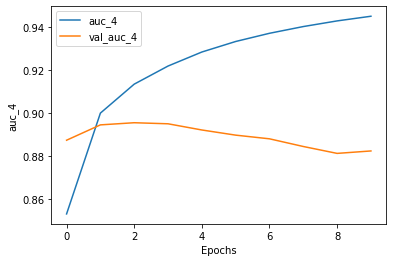

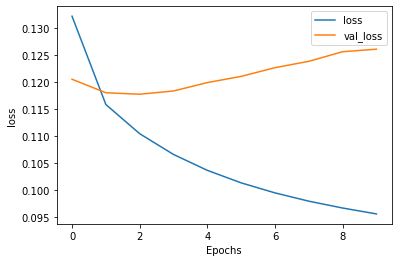

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_4")
plot_graphs(history, "loss")

# MODEL 3 
# sans callback 
# avec dropout

https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/


https://www.kaggle.com/code/bansodesandeep/multilabel-cuisine-classification-cnn-dnn-lstm

In [ ]:
#  Here the length refers to the number of rows of the filter, 
# here it is the dimension of the entire word embedding or the entire character representation
filter_length = 300


model = tf.keras.Sequential()
model.add(Embedding(vocab_size, 20, input_length=max_length))
model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(training_labels.shape[1]))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(multi_label=True)])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]


num_epochs= 10
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
6250/6250 - 25s - loss: 0.1407 - auc_7: 0.7028 - val_loss: 0.1479 - val_auc_7: 0.7979 - 25s/epoch - 4ms/step
Epoch 2/10
6250/6250 - 23s - loss: 0.1284 - auc_7: 0.7878 - val_loss: 0.1603 - val_auc_7: 0.8156 - 23s/epoch - 4ms/step
Epoch 3/10
6250/6250 - 24s - loss: 0.1252 - auc_7: 0.8070 - val_loss: 0.1807 - val_auc_7: 0.8127 - 24s/epoch - 4ms/step
Epoch 4/10
6250/6250 - 26s - loss: 0.1231 - auc_7: 0.8166 - val_loss: 0.1927 - val_auc_7: 0.8164 - 26s/epoch - 4ms/step
Epoch 5/10
6250/6250 - 23s - loss: 0.1216 - auc_7: 0.8246 - val_loss: 0.2038 - val_auc_7: 0.8174 - 23s/epoch - 4ms/step
Epoch 6/10
6250/6250 - 24s - loss: 0.1202 - auc_7: 0.8295 - val_loss: 0.2154 - val_auc_7: 0.8221 - 24s/epoch - 4ms/step
Epoch 7/10
6250/6250 - 23s - loss: 0.1193 - auc_7: 0.8339 - val_loss: 0.2172 - val_auc_7: 0.8260 - 23s/epoch - 4ms/step
Epoch 8/10
6250/6250 - 23s - loss: 0.1182 - auc_7: 0.8388 - val_loss: 0.2206 - val_auc_7: 0.8252 - 23s/epoch - 4ms/step
Epoch 9/10
6250/6250 - 23s - loss: 0.117

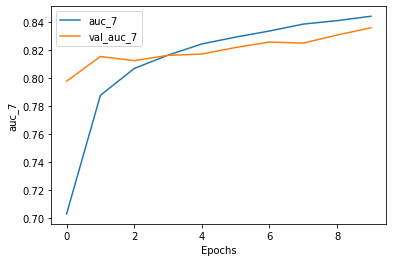

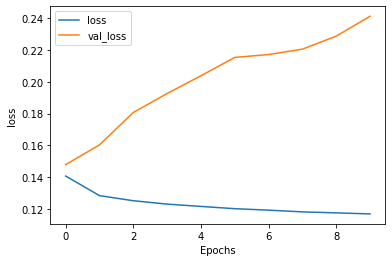

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_7")
plot_graphs(history, "loss")

# MODEL 3 
# sans callback 
# avec dropout
# sans filter length, kernel size null

In [ ]:
#  Here the length refers to the number of rows of the filter, 
# here it is the dimension of the entire word embedding or the entire character representation
filter_length = 100


model = tf.keras.Sequential()
model.add(Embedding(vocab_size, 20, input_length=max_length))
model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(training_labels.shape[1]))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(multi_label=True)])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]


num_epochs= 10
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
6250/6250 - 26s - loss: 0.1445 - auc_10: 0.6742 - val_loss: 0.1519 - val_auc_10: 0.7753 - 26s/epoch - 4ms/step
Epoch 2/10
6250/6250 - 23s - loss: 0.1314 - auc_10: 0.7669 - val_loss: 0.1537 - val_auc_10: 0.8055 - 23s/epoch - 4ms/step
Epoch 3/10
6250/6250 - 24s - loss: 0.1278 - auc_10: 0.7920 - val_loss: 0.1585 - val_auc_10: 0.8093 - 24s/epoch - 4ms/step
Epoch 4/10
6250/6250 - 23s - loss: 0.1254 - auc_10: 0.8050 - val_loss: 0.1699 - val_auc_10: 0.8068 - 23s/epoch - 4ms/step
Epoch 5/10
6250/6250 - 23s - loss: 0.1238 - auc_10: 0.8126 - val_loss: 0.1812 - val_auc_10: 0.8006 - 23s/epoch - 4ms/step
Epoch 6/10
6250/6250 - 23s - loss: 0.1224 - auc_10: 0.8200 - val_loss: 0.1959 - val_auc_10: 0.8048 - 23s/epoch - 4ms/step
Epoch 7/10
6250/6250 - 23s - loss: 0.1213 - auc_10: 0.8243 - val_loss: 0.2129 - val_auc_10: 0.8027 - 23s/epoch - 4ms/step
Epoch 8/10
6250/6250 - 23s - loss: 0.1205 - auc_10: 0.8279 - val_loss: 0.2172 - val_auc_10: 0.8026 - 23s/epoch - 4ms/step
Epoch 9/10
6250/6250 - 2

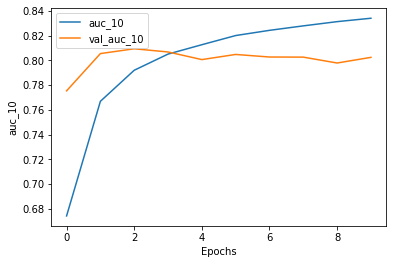

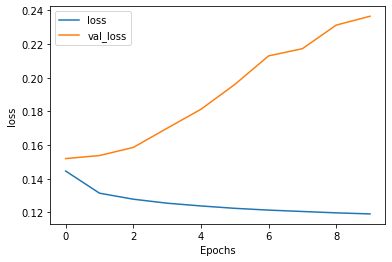

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_10")
plot_graphs(history, "loss")